## Domaća zadaća 3

### Zadatak

Analizirajte kretanje cijene zlata u zadnjih mjesec dana. Cijene s intervalom 1min dostupne su u dokumentu u prilogu. Primjenom ARIMA modela nad iznosom cijene Open prognozirajte cijenu zlata u sljedećih 14 dana i izračunajte interval 95% pouzdanosti.

Hint 1. Statsmodel ima integrirane potrebne funkcije

Hint 2. Ovaj model nije najprikladniji kao podloga za odluku o kupovini ili prodaji plemenitih metala pa to i ne preporučam. :)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Load data in data frame
#df = pd.read_csv('XAUUSD_Candlestick_1_M_BID_01.03.2022-06.04.2022.csv', index_col=0, parse_dates=True, dayfirst = True, cache_dates = True)
df = pd.read_csv('XAUUSD_Candlestick_1_M_BID_01.03.2022-06.04.2022.csv', parse_dates=True, dayfirst = True, cache_dates = True)

# Replace whitespace
df.columns = df.columns.str.replace(' ', '')

df.head(5)

,Localtime,Open,High,Low,Close,Volume
0,01.03.2022 00:00:00.000 GMT+0100,1908.638,1908.738,1906.658,1907.158,30759.9995
1,01.03.2022 00:01:00.000 GMT+0100,1907.298,1907.988,1907.298,1907.848,23119.9991
2,01.03.2022 00:02:00.000 GMT+0100,1907.858,1908.638,1907.858,1908.598,8820.0001
3,01.03.2022 00:03:00.000 GMT+0100,1908.528,1908.558,1908.108,1908.118,15320.0002
4,01.03.2022 00:04:00.000 GMT+0100,1908.008,1908.318,1907.928,1908.308,11719.9998


In [3]:
# Remove periods when market was closed
df.Open = df.Open.loc[df.Open.shift() != df.Open]

df.dropna(subset = ["Open"], inplace=True)

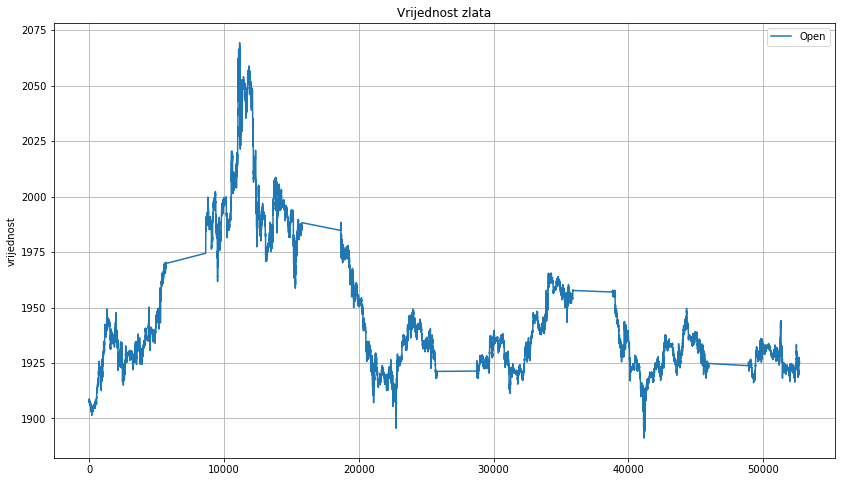

In [4]:
# Plot local time - open
df.plot(use_index = True, y=1, title='Vrijednost zlata', figsize=(14,8), grid=True, legend=True, ylabel='vrijednost')

ARIMA model sastoji se od AR (Auto Regression) i MA (Moving average) modela. To znači da za izračun Y-a koristi vlastite lags i predviđene error lags.

Jednadžba izgleda ovako:

<img src='https://www.machinelearningplus.com/wp-content/uploads/2019/02/Equation-4-min.png'>

Prvi korak ARIMA modela jest napraviti Time series stacionarnima, tj. td. vrijednosti ne ovise o vremenu u kojem su uzete. To se radi diferenciranjem, tj. oduzimanjem prethodne vrijednosti sa trenutačnom.

### Stacionarnost

Koristim Augmented Dickey Fuller Test koji postavlja hipoteze:

* H0 - time series nije stacionaran
* H1 - time series je stacionaran

In [5]:
stationarity = adfuller(df.Open.values)
print('ADF Statistic: %f' % stationarity[0])
print('p-value: %f' % stationarity[1])
print('Number of used lags: %d' % stationarity[2])

ADF Statistic: -2.130470
p-value: 0.232440
Number of used lags: 53


Budući da smo dobili p-value p > 0.05, ne možemo odbaciti null hipotezu i zaključiti da je time-series stacionaran. Radimo diferencijaciju

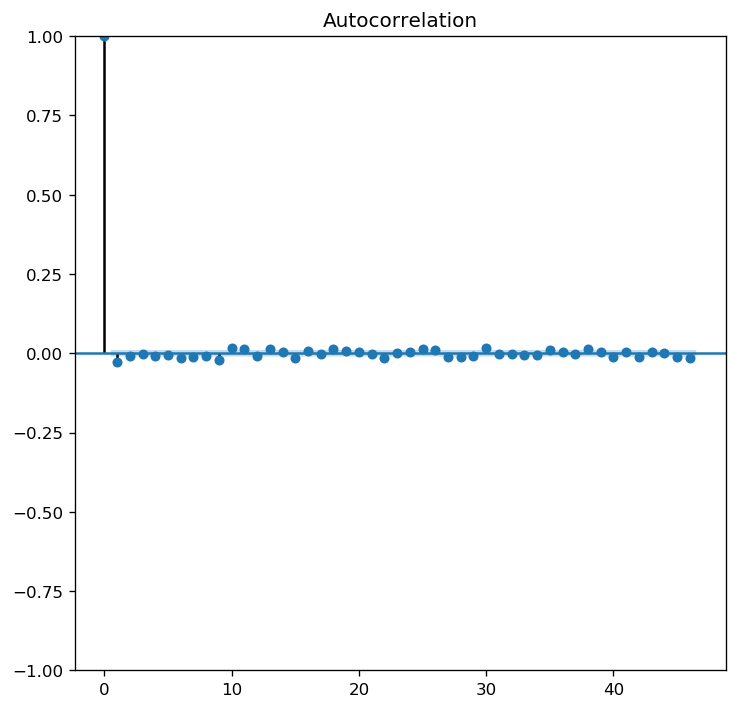

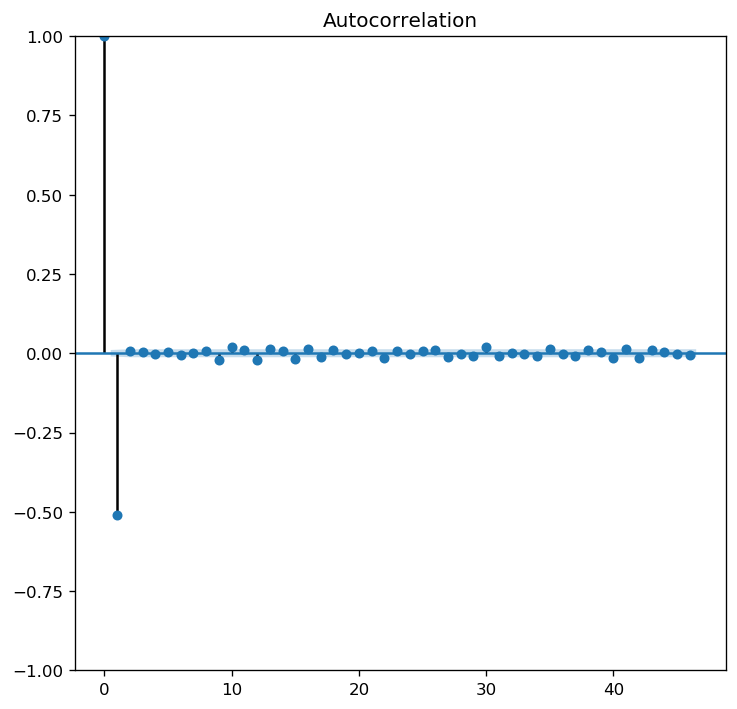

In [6]:
# Plot autokorelaciju s prvom razinom diferencijacije
plt.rcParams.update({'figure.figsize':(7,7), 'figure.dpi':120})
plot_acf(df.Open.diff().dropna());

# Plot autokorelaciju s drugom razinom diferencijacije
plot_acf(df.Open.diff().diff().dropna());

Vidimo da je autokorelacija (korelacija između iste varijable između dva uzastopna vremenska intervala) prve i druge diferencijacije skoro jednaka. Budući da na drugoj diferencijaciji imamo jače izraženi drugi lag koji poprima negativnu vrijednost, a bolje je uvijek uzeti što manji stupanj diferencijacije, odlučujemo se za diferencijaciju stupnja d = 1, tj. odabirom parametra q = 1 ili q = 2.

#### Ponovna provjera stacionarnosti s diferenciranim time series

In [7]:
stationarity = adfuller(df.Open.diff().dropna().values)
print('ADF Statistic: %f' % stationarity[0])
print('p-value: %f' % stationarity[1])
print('Number of used lags: %d' % stationarity[2])

ADF Statistic: -26.749141
p-value: 0.000000
Number of used lags: 52


Kao što vidimo po rezultatima, diferencijacija stupnja 1 daje vrijednost p < 0.05

Također, u ARIMA modelu, trebamo odrediti vrijednost MA parametra (q). ACF graf govori koliko MA vrijednosti treba da se makne autokorelacija u stacioniziranim serijama. Uzimamo vrijednost sa ACF grafa koja je iznad signicifant line, u našem slučaju možemo uzeti vrijednost q = 1 ili q = 2, ovisno koju ćemo vrijednost bolju dobiti.

### Parcijalna autokorelacija

/home/silvio/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


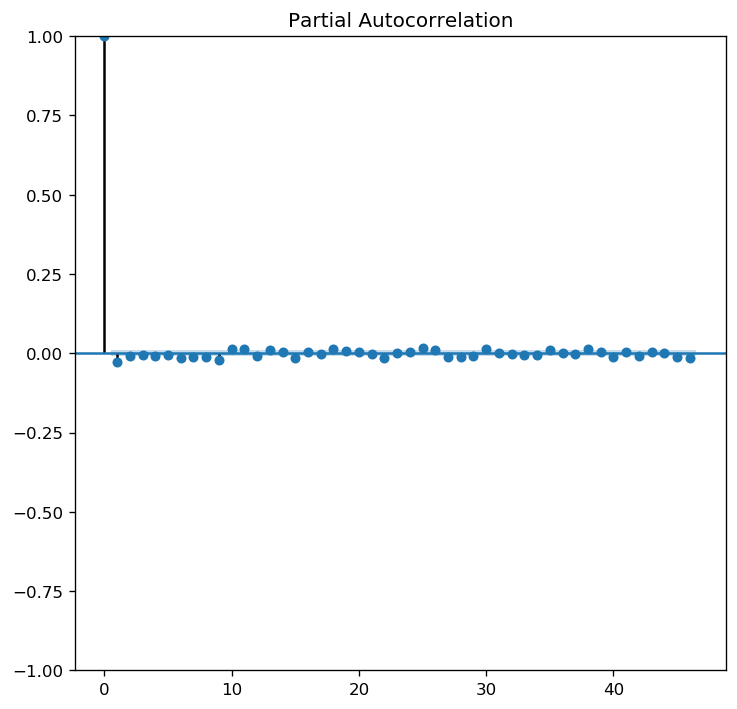

In [8]:
plot_pacf(df.Open.diff().dropna());

Parijcalna autokorelacija zapravo je korelacija koja nastaje nakon što se makne efekt korelacije zbog različitih duljina lagova. Budući da je u našem slučaju duljina lagova skoro uvijek jednaka, graf parcijalne autokorelacije i autokorelacije vrlo je sličan. Na grafu gledamo koliko se prvih lagova nalazi izvan significant levela, i ta vrijednost može biti maksimalna za parametar p. U našem slučaju, p < 4.

### ARIMA 

In [20]:
# order (p,d,q)
order = (2, 0, 1)
model = ARIMA(df.Open, order=order)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                36488
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -38840.331
Date:                Sun, 15 May 2022   AIC                          77690.661
Time:                        09:38:13   BIC                          77733.185
Sample:                    03-01-2022   HQIC                         77704.179
                         - 04-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1945.7814      9.748    199.612      0.000    1926.676    1964.887
ar.L1          1.4301      0.063     22.553      0.000       1.306       1.554
ar.L2         -0.4303      0.063     -6.788      0.0

*Napomena*: probao sam i različite vrijednosti ARIMA(p,d,q). Također, probao sam i SARIMAX funkciju te VARIMAX koja se koristi za multivarijantnu analizu. Odabrao sam (2,1,1) jer ima najmanju vrijednost AIC-a, a i p-vrijednosti koeficijenata su nula.

### Prediction

In [21]:
#Prediction za sljedeća 4 dana
n_predictions = 4 * 24 * 60
print(n_predictions)

5760


#### Slijedi jako naporan dio koji mi je uzeo puno vremena - postavljanje indeksa na točno određen vremenski oblik i plotanje

In [22]:
# Postavi varijablu Localtime tipa datetime
df.Localtime = pd.to_datetime(df.Localtime, utc = True, dayfirst = True)

AttributeError: 'DataFrame' object has no attribute 'Localtime'

In [ ]:
# Kreiraj dates koji će sadržavati vrijednosti indeksa za 14 dana
dates = pd.DataFrame({'date': pd.date_range(start=df.Localtime.iloc[-1], periods= n_predictions, freq='min', closed='right')})
dates.head()

In [ ]:
dates.shape

In [ ]:
# Set index as datetime
df.index = pd.to_datetime(df.Localtime, utc = True, dayfirst = True)

# Set frequency to minutes
df.index = pd.DatetimeIndex(df.index).to_period('min')

# Drop localtime
del df['Localtime']

In [ ]:
#future_df['new_forecast'] = model_fit.forecast(steps = (future_df.shape[0] - df.shape[0]))
novo = model_fit.predict(start = df.shape[0], end = df.shape[0] + n_predictions - 2)
novo.values

In [ ]:
## Napravi novi data frame koji će sadržavati vrijednost indeksa kao datetime te vrijednosti predikcije kao values
novi_df = pd.DataFrame(index=dates.date.to_list()[0:] ,columns=['Open'])
novi_df.Open = novo.values

In [ ]:
novi_df

In [ ]:
df['Open'].plot(figsize=(12, 8)) 
novi_df['Open'].plot()